# Classificação da morfologia do esperma humano baseada em DCNN

#### Daniel Falci

Escrever um texto legal depois

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

Using TensorFlow backend.
/usr/lib64/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os
%matplotlib inline


# Pré processamento das imagens

As imagens lidas na base de dados estão originalmente dispostas em um formato 131x131. Existem 

* Crop 128x128 ou Stretch para 128x128

In [3]:
imagePaths = sorted(list(paths.list_images('HuSHem')))
random.seed(35)
random.shuffle(imagePaths)


HuSHem/01_Normal/image_018.BMP


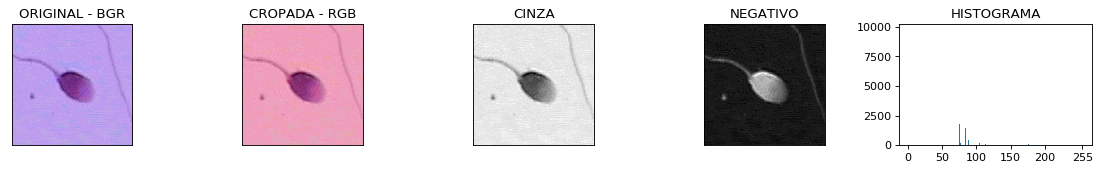

HuSHem/02_Tapered/image_024.BMP


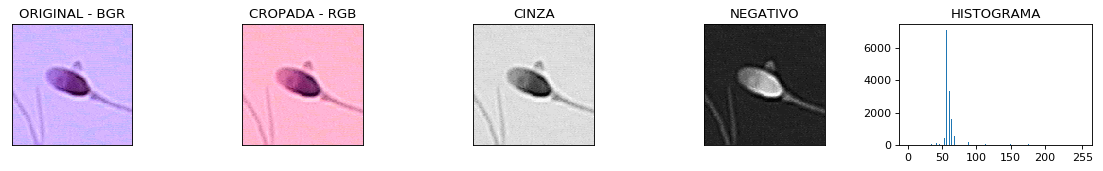

HuSHem/01_Normal/image_031.BMP


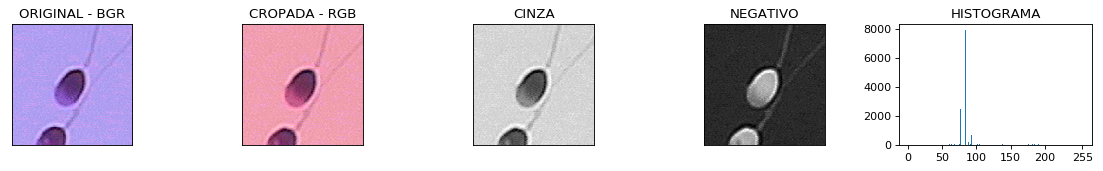

HuSHem/03_Pyriform/image_037.BMP


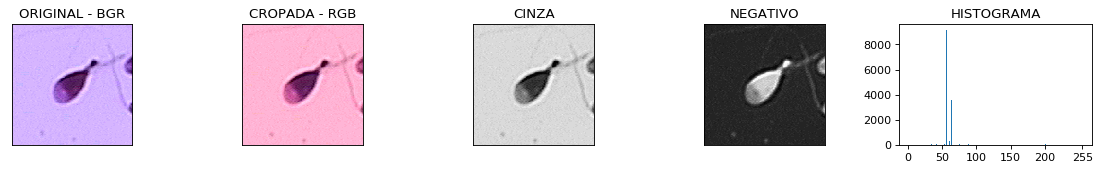

HuSHem/04_Amorphous/image_009.BMP


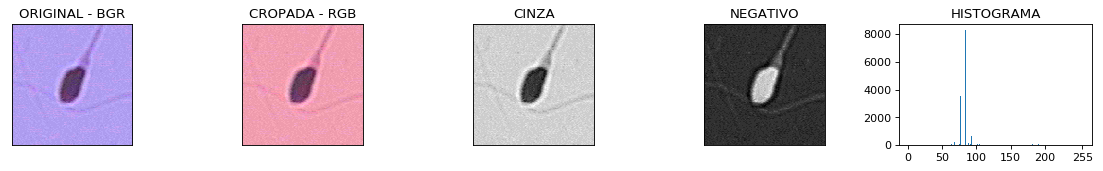

TOTAL DE IMAGENS CARREGADAS NA BASE DE DADOS : 216


In [4]:
data = []
labels = []

def showImage(image, label):
    print label
    plt.imshow(image, cmap="gray", vmin=0, vmax=255)
    plt.show()
    
    
def crop(img, area):
    def pad_img_to_fit_bbox(img, x1, x2, y1, y2):
        img = cv2.copyMakeBorder(img, - min(0, y1), max(y2 - img.shape[0], 0), -min(0, x1), max(x2 - img.shape[1], 0),cv2.BORDER_REPLICATE)
        y2 += -min(0, y1)
        y1 += -min(0, y1)
        x2 += -min(0, x1)
        x1 += -min(0, x1)
        return img, x1, x2, y1, y2
    
    
    x1,y1,x2,y2 = area
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        img, x1, x2, y1, y2 = pad_img_to_fit_bbox(img, x1, x2, y1, y2)
    return img[y1:y2, x1:x2, :]

def negativo(image):
    return (255-image)

def show_img_hist(img):
    plt.hist(img.flatten(),256,[0,256])
    plt.show()
    
def linear_contrast(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    
    return cdf[img]

def threshold(image):
    ret,image = cv2.threshold(image,0,110,cv2.THRESH_TOZERO)
    return image

    
    
def do_pipeline(filename, image, show_sample=False):
    titles = []
    samples = []
    
    def add_img(img, title):
        titles.append(title)
        samples.append(img)
    add_img(image, 'ORIGINAL - BGR')
    
    if not image.shape == (131, 131, 3):
        image = cv2.resize(image, (128, 128))
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cropped = crop(image, (1, 1, 129, 129))
    add_img(cropped, 'CROPADA - RGB')
    
    gray_scale = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    add_img(gray_scale, 'CINZA')
    

    neg = negativo(gray_scale)
    add_img(neg, 'NEGATIVO')
    
#     thresh = threshold(neg)
#     add_img(thresh, 'Threshold')
    
    if show_sample:
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
        print filename
        for i in xrange(len(samples)):
            plt.subplot(1,len(samples)+1,i+1),plt.imshow(samples[i],'gray')
            plt.title(titles[i])
            plt.xticks([]),plt.yticks([])
        fig.set_figheight(2)
        plt.subplot(1, len(samples)+1, len(samples)+1),plt.hist(neg.flatten(),256,[0,256])
        plt.title('HISTOGRAMA')
        plt.xticks([0, 50, 100, 150, 200, 255])
        plt.show()
        
    return neg
        
    

i=0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    data.append(img_to_array(do_pipeline(imagePath, cv2.imread(imagePath, cv2.IMREAD_UNCHANGED), True if i < 5 else False)))
    labels.append(label)
    
    
    i+=1

print 'TOTAL DE IMAGENS CARREGADAS NA BASE DE DADOS : {qu}'.format(qu=len(data))
    
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [5]:
def img_partition():
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return (x_train, y_train, x_test, y_test)

def get_normalized_data():
    x_train, y_train, x_test, y_test = img_partition()
    x_train = x_train /255
    x_test = x_test / 255
    return (x_train, y_train, x_test, y_test)    

x_train, y_train, x_test, y_test = img_partition()

## Etapa de geração de imagens

O conjunto de dados original é pequeno (216 imagens). Um modelo de rede neural treinado em uma base de imagens deste tamanho tende a fazer overfit muito cedo e normalmente tem uma baixa capacidade de generalização em dados não vistos. 

Para atenuar este problema, utilizamos técnicas para aumentar artificialmente o tamanho do corpus de treinamento. Para cada imagem, geramos 32 imagens com zoom de 15% e rotação aleatória. O fill da rotação selecionado é o reflect. Como o nosso objetivo é classificar a morfologia da cabeça do espermatozóide, é importante que o oversampling não deforme demis a imagem original, o que provocaria uma queda na capacidade de classificação.



Veja abaixo o resultado do nosso tratamento

(1, 128, 128, 1)


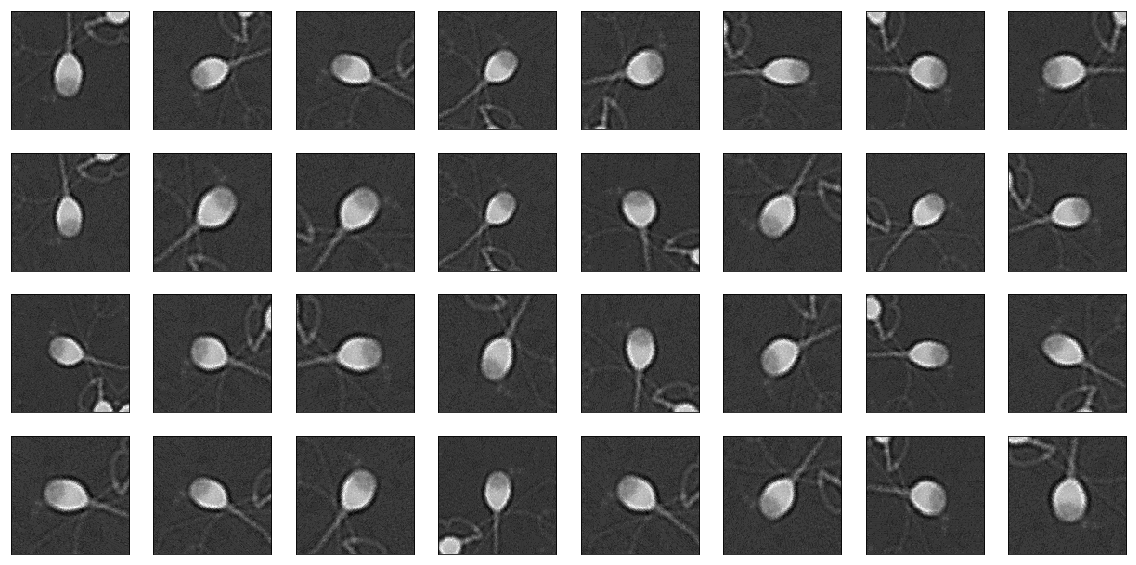

In [6]:

# generator = ImageDataGenerator(rotation_range=180)
# generator = ImageDataGenerator(zoom_range=0.15, fill_mode="reflect")
generator = ImageDataGenerator(rotation_range=180, horizontal_flip=True, zoom_range=0.15, fill_mode="reflect")
generator.fit(x_train)

plt.rcParams['figure.figsize'] = [20, 10]

imgs = []

teste = x_train[:1]

print teste.shape
batches = 0
nimg = 0
for gen in generator.flow(teste, batch_size=32):
    batches +=1
    for x in gen:
        img = np.asarray(x).reshape((128, 128))
        plt.subplot(4,8,nimg+1),plt.imshow(img,'gray', animated=True)
        plt.xticks([]),plt.yticks([])
        nimg+=1
    if batches >= 32:
        plt.show()
        break



In [28]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(8, 8), strides=(1, 1), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.15))
model.add(Dense(4, activation='softmax'))

In [30]:
import keras
from keras.callbacks import ModelCheckpoint

model.summary()

filepath="weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 121, 121, 32)      2080      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 57, 57, 64)        32832     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 10816)             0         
__________

Modelo pronto

# Treinando o modelo



In [22]:
x_train, y_train, x_test, y_test = get_normalized_data()

In [31]:
epocas = 150
augX = ImageDataGenerator(rotation_range=180, horizontal_flip=True, zoom_range=0.15, fill_mode="reflect")
augX.fit(x_train)

history = model.fit_generator(augX.flow(x_train, y_train, batch_size=32), steps_per_epoch= len(x_train) //4, epochs=epocas, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks_list)

Epoch 1/150
43/43 [==============================] - 3s - loss: 1.3858 - acc: 0.2683 - val_loss: 1.4128 - val_acc: 0.2727
Epoch 2/150
43/43 [==============================] - 2s - loss: 1.3040 - acc: 0.3989 - val_loss: 1.1921 - val_acc: 0.5909
Epoch 3/150
43/43 [==============================] - 2s - loss: 1.2206 - acc: 0.4583 - val_loss: 1.0448 - val_acc: 0.5455
Epoch 4/150
43/43 [==============================] - 2s - loss: 1.0901 - acc: 0.5108 - val_loss: 0.9759 - val_acc: 0.5682
Epoch 5/150
43/43 [==============================] - 2s - loss: 1.0174 - acc: 0.5451 - val_loss: 0.8407 - val_acc: 0.6591
Epoch 6/150
43/43 [==============================] - 2s - loss: 0.9857 - acc: 0.5565 - val_loss: 0.9239 - val_acc: 0.5455
Epoch 7/150
43/43 [==============================] - 2s - loss: 0.8681 - acc: 0.6291 - val_loss: 0.7481 - val_acc: 0.7045
Epoch 8/150
43/43 [==============================] - 2s - loss: 0.8224 - acc: 0.6416 - val_loss: 0.6727 - val_acc: 0.7500
Epoch 9/150
43/43 [=====

43/43 [==============================] - 2s - loss: 0.1754 - acc: 0.9301 - val_loss: 0.4750 - val_acc: 0.8409
Epoch 69/150
43/43 [==============================] - 2s - loss: 0.1712 - acc: 0.9336 - val_loss: 0.3566 - val_acc: 0.8636
Epoch 70/150
43/43 [==============================] - 2s - loss: 0.1188 - acc: 0.9566 - val_loss: 0.3940 - val_acc: 0.8864
Epoch 71/150
43/43 [==============================] - 2s - loss: 0.1138 - acc: 0.9665 - val_loss: 0.4906 - val_acc: 0.8636
Epoch 72/150
43/43 [==============================] - 2s - loss: 0.1136 - acc: 0.9576 - val_loss: 0.3494 - val_acc: 0.9091
Epoch 73/150
43/43 [==============================] - 2s - loss: 0.1407 - acc: 0.9523 - val_loss: 0.4518 - val_acc: 0.8636
Epoch 74/150
43/43 [==============================] - 2s - loss: 0.1274 - acc: 0.9502 - val_loss: 0.2795 - val_acc: 0.9091
Epoch 75/150
43/43 [==============================] - 2s - loss: 0.1375 - acc: 0.9571 - val_loss: 0.2653 - val_acc: 0.9318
Epoch 76/150
43/43 [=========

43/43 [==============================] - 2s - loss: 0.1265 - acc: 0.9603 - val_loss: 0.4489 - val_acc: 0.8864
Epoch 138/150
43/43 [==============================] - 2s - loss: 0.0572 - acc: 0.9823 - val_loss: 0.4761 - val_acc: 0.8636
Epoch 139/150
43/43 [==============================] - 2s - loss: 0.0525 - acc: 0.9772 - val_loss: 0.3964 - val_acc: 0.8864
Epoch 140/150
43/43 [==============================] - 2s - loss: 0.0766 - acc: 0.9750 - val_loss: 0.4123 - val_acc: 0.8636
Epoch 141/150
43/43 [==============================] - 2s - loss: 0.0758 - acc: 0.9724 - val_loss: 0.3268 - val_acc: 0.8636
Epoch 142/150
43/43 [==============================] - 2s - loss: 0.0582 - acc: 0.9799 - val_loss: 0.3831 - val_acc: 0.9318
Epoch 143/150
43/43 [==============================] - 2s - loss: 0.0516 - acc: 0.9774 - val_loss: 0.4423 - val_acc: 0.9091
Epoch 144/150
43/43 [==============================] - 2s - loss: 0.1153 - acc: 0.9550 - val_loss: 0.3964 - val_acc: 0.9318
Epoch 145/150
43/43 [=

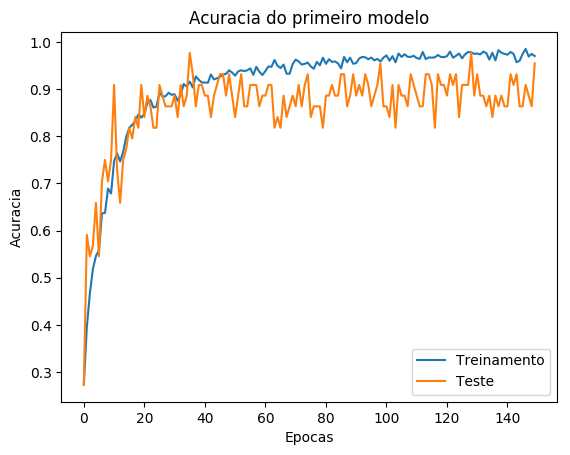

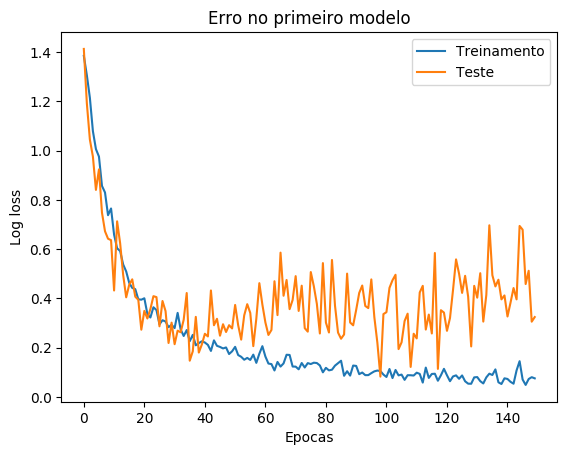

In [32]:
plt.rcdefaults() 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Acuracia do primeiro modelo')
plt.ylabel('Acuracia')
plt.xlabel('Epocas')
plt.legend(['Treinamento', 'Teste'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Erro no primeiro modelo')
plt.ylabel('Log loss')
plt.xlabel('Epocas')
plt.legend(['Treinamento', 'Teste'], loc='upper right')
plt.show()

# E agora? 

## arrumar o outro dataset? só escrever o artigo?


### Implementação do tesorflow com modelo simples

In [7]:
import tensorflow as tf


x = tf.placeholder("float", [None, 128,128,1])
y = tf.placeholder("float", [None, 4])

def convolucao(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def max_pooling(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')


weights = {
    'wc1': tf.get_variable('W0', shape=(8,8,1,32), initializer=tf.contrib.layers.xavier_initializer()), # primeira convolucao
    'wc2': tf.get_variable('W1', shape=(4,4,32,64), initializer=tf.contrib.layers.xavier_initializer()),# segunda convolucao
    'wc3': tf.get_variable('W2', shape=(3,3,64,64), initializer=tf.contrib.layers.xavier_initializer()),  # terceira convolucao
    
    'wd1': tf.get_variable('W3', shape=(16*16*64,1024), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(1024,4), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    
    'bd1': tf.get_variable('B3', shape=(1024), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(4), initializer=tf.contrib.layers.xavier_initializer()),
}

conv1 = convolucao(x, weights['wc1'], biases['bc1'])
conv1 = max_pooling(conv1, k=2)

conv2 = convolucao(conv1, weights['wc2'], biases['bc2'])
conv2 = max_pooling(conv2, k=2)

conv3 = convolucao(conv2, weights['wc3'], biases['bc3'])
conv3 = max_pooling(conv3, k=2)

fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
fc1 = tf.nn.relu(fc1)

pred = tf.add(tf.matmul(fc1, weights['out']), biases['out'])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


init = tf.global_variables_initializer()



In [8]:
x_train, y_train, x_test, y_test = get_normalized_data()
training_iters = 100
batch_size=8
with tf.Session() as sess:
    sess.run(init) 
    
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(x_train)//batch_size):
            
            batch_x = x_train[batch*batch_size:min((batch+1)*batch_size,len(x_train))]
            batch_y = y_train[batch*batch_size:min((batch+1)*batch_size,len(y_train))] 
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
        print("Epoca " + str(i) + " -  loss = " + "{:.6f}".format(loss) + " - acuracia = " + "{:.5f}".format(acc))
        test_acc, valid_loss = sess.run([accuracy,cost], feed_dict={x: x_test,y : y_test})
        
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        
        print"Acuracia no teste:","{:.5f}".format(test_acc)
    summary_writer.close()

Epoca 0 -  loss = 1.373734 - acuracia = 0.37500
Acuracia no teste: 0.18182
Epoca 1 -  loss = 1.389959 - acuracia = 0.12500
Acuracia no teste: 0.27273
Epoca 2 -  loss = 1.219047 - acuracia = 0.50000
Acuracia no teste: 0.29545
Epoca 3 -  loss = 1.001575 - acuracia = 0.62500
Acuracia no teste: 0.34091
Epoca 4 -  loss = 1.037423 - acuracia = 0.75000
Acuracia no teste: 0.27273
Epoca 5 -  loss = 0.853988 - acuracia = 0.62500
Acuracia no teste: 0.29545
Epoca 6 -  loss = 0.765715 - acuracia = 0.62500
Acuracia no teste: 0.27273
Epoca 7 -  loss = 0.744514 - acuracia = 0.75000
Acuracia no teste: 0.40909
Epoca 8 -  loss = 0.677042 - acuracia = 0.62500
Acuracia no teste: 0.38636
Epoca 9 -  loss = 0.492518 - acuracia = 0.87500
Acuracia no teste: 0.38636
Epoca 10 -  loss = 0.388897 - acuracia = 0.87500
Acuracia no teste: 0.38636
Epoca 11 -  loss = 0.220742 - acuracia = 1.00000
Acuracia no teste: 0.40909
Epoca 12 -  loss = 0.329592 - acuracia = 1.00000
Acuracia no teste: 0.40909
Epoca 13 -  loss = 0.2